# Image Calssification using AWS SageMaker: Classification of Dog Breeds


**Brief Summary of the Project**: 

In this Notebook we showcase the implementation of Image Classification Model for classifying Dog Breeds. 

Following are the key steps in the implementation:

* The DataSets consist of Dog Images for 133 Breeds -- Dataset has been proided by Udacity and has been stored in unzipped format in s3 Bucket and in the workspace

* We have used Pre-Trained ResNet50 Model from Pytorch Vision Library -- We will be using the concept of Transfer Learning so all existing convolutional Layers in this model have been frozen

* Our Implementation further adds two Fully connected layers with 256 and 133 neurons (output) respectively to the output of ResNet50 pre-trained model -- Note that We will be training only these two FC Layers 

* We first use HyperParameter Tuning to identify the best Hyperparameters to use for Training the Model -- Minimisation of Average Loss is used in identification of the best set of Hyperparameters -- Tunable Hyperparametes chosen are Batch size and Learning Rate

* Using these identified Hyperparameters, we Train and Fine Tune our NN Model (ResNet50 + 2FC) 

* During Training, we add configurations for profiling and Debugging our Model by adding hooks in Training and Testing Phases -- This is helpful in understanding how the model is training

* Finally we deploy this model using an inerence script which is used in making predictions on test images


In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install torch torchvision tqdm
!pip install -U smdebug

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Killed
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-many

In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
from smdebug import modes
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import IPython

[2022-03-08 08:16:19.947 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


## Dataset

The Dataset consists of Images of 133 Dog Breeds. It has been provided by Udacity and has been saved in S3 Bucket (unzipped form) and in the workspace. Below we show pictures for few of the Dog Breeds 

Bedlington_terrier_01355


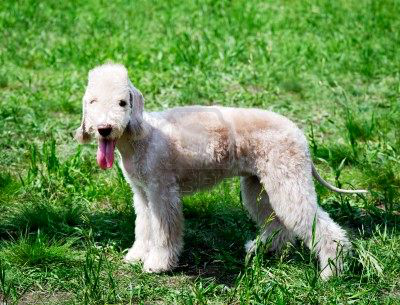

German_pinscher_04831


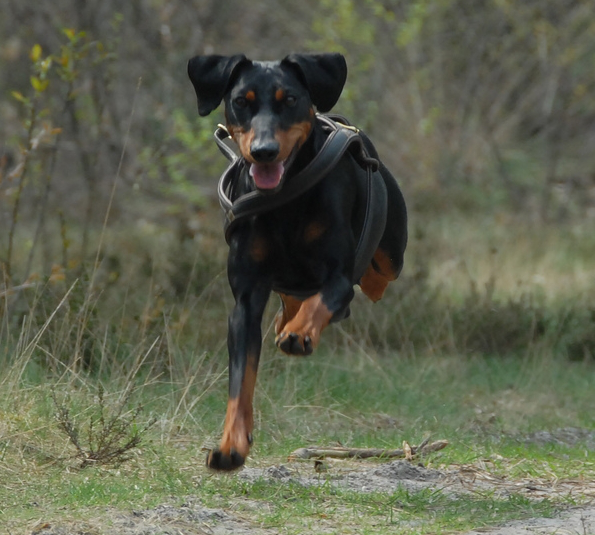

Alaskan_malamute_00360


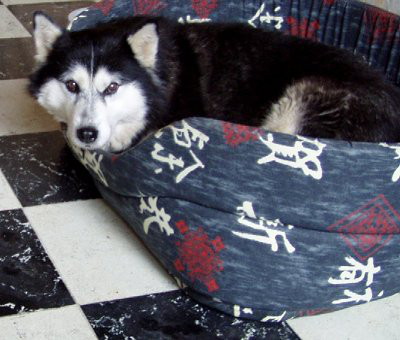

In [4]:
from PIL import Image
import io
import os

directory = './DisplayImages'
L = [item for item in os.listdir(directory) if '.jpg' in item]

for item in L:
    
    image_path = os.path.join(directory, item)
    
    with open(image_path, "rb") as f:
        print(item.split('.')[0])
        img = f.read()
        display(Image.open(io.BytesIO(img)))


In [6]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2022-03-08 08:18:34--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 3.5.163.157
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|3.5.163.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  32.2MB/s    in 44s     

2022-03-08 08:19:19 (24.8 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Affenp

In [8]:
client = boto3.client('s3')
role = get_execution_role()
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
bucket = sagemaker_session.default_bucket()

prefix ="dogImages"
print("Starting to uploading dogImages")

inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)
print(f"Input path ( S3 file path ): {inputs}")

Starting to uploading dogImages
Input path ( S3 file path ): s3://sagemaker-us-east-1-950138119485/dogImages


In [9]:
train_folder = 'dogImages/train'
validation_folder = 'dogImages/valid'
test_folder = 'dogImages/test'

## Checking that Data is uploaded correctly 

In the Below Cells, we run rudimentary check to ensure that the data has been uploaded correctly to our S3 bucket -- Any discrepancies found in this step should be remediated first before proceeding.  

We find that the Training, Testing and Validation Folders have images for all the same 133 Dog Breeds  

In [10]:
import re

def get_all_objects(bucket, prefix):
    paginator = client.get_paginator('list_objects')
    pages = paginator.paginate(Bucket=bucket, Prefix=prefix)
    cont = []
    files = []
    folders = []
    for page in pages: 
        cont.append(page['Contents'])
    for item in cont:
        for subs in item:
            files.append(subs['Key'])
    return files

def distinct_classes(expression, files):
    classes = []
    for item in files:
        if re.search(expression, item):
            classes.append(re.search(expression, item).group())
    return set(classes)

In [11]:
exp = '([+-]?(?=\.\d|\d)(?:\d+)?(?:\.?\d*))(?:[eE]([+-]?\d+))?[a-zA-Z]+'

In [12]:
train_files = get_all_objects(bucket, train_folder)
train_classes = distinct_classes(exp, train_files)
val_files = get_all_objects(bucket, validation_folder)
val_classes = distinct_classes(exp, val_files)
test_files = get_all_objects(bucket, test_folder)
test_classes = distinct_classes(exp, test_files)

In [13]:
if train_classes == val_classes == test_classes:
    print('Train, Test and Val Folders have images for all the (same) Dog Breeds \n')
    print('The Dog Breeds used are \n')
    for item in train_classes:
        print(item)

Train, Test and Val Folders have images for all the (same) Dog Breeds 

The Dog Breeds used are 

063.English
012.Australian
113.Old
027.Bloodhound
039.Bull
036.Briard
016.Beagle
070.German
082.Havanese
068.Flat
011.Australian
088.Irish
112.Nova
048.Chihuahua
022.Belgian
108.Norwegian
131.Wirehaired
074.Giant
090.Italian
081.Greyhound
044.Cane
104.Miniature
097.Lakeland
107.Norfolk
017.Bearded
118.Pembroke
076.Golden
103.Mastiff
115.Papillon
133.Yorkshire
102.Manchester
033.Bouvier
126.Saint
077.Gordon
040.Bulldog
117.Pekingese
075.Glen
080.Greater
071.German
004.Akita
013.Australian
094.Komondor
045.Cardigan
056.Dachshund
099.Lhasa
125.Portuguese
058.Dandie
098.Leonberger
057.Dalmatian
096.Labrador
072.German
038.Brussels
014.Basenji
052.Clumber
019.Bedlington
110.Norwegian
031.Borzoi
029.Border
083.Ibizan
109.Norwegian
073.German
054.Collie
111.Norwich
129.Tibetan
106.Newfoundland
101.Maltese
079.Great
008.American
085.Irish
122.Pointer
003.Airedale
035.Boykin
034.Boxer
116.Parson
07

In [14]:
# We have verified that the Train classes, Validation classes and Test Classes are all the same
print("Number of Train Classes: "+ str(len(train_classes)))
print("Number of Test Classes: "+ str(len(test_classes)))
print("Number of Val Classes: "+ str(len(val_classes)))

Number of Train Classes: 133
Number of Test Classes: 133
Number of Val Classes: 133


## Hyperparameter Tuning

The Model used im our implementation is ResNet50 Model with 2 additional Fully Connected Layers in the output of ResNet50. ResNet50 has 50 Layers which are trained on over a million Images from ImageNet Database. Hence, it has a architecture useful for image-recognition tasks.

We are using Adam Optimizer for the Model, following hyperparameters have been tuned in the implementation below (using hpo.py script):

* Learning Rate -- Range is from 0.0001 to 0.1
* Batch Size -- Three categorical values of 32, 64 and 128

Note that Average Test Loss is the criteria used in identification of optimal hyperparameters, minimal values of this metric is preferred. We also extract the loss and accuracy values using a regex expression

In [15]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.0001, 0.1),
    "batch_size": CategoricalParameter([ 32, 64, 128]),
}
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [16]:
from  sagemaker.pytorch import PyTorch

role  = get_execution_role()
estimator = PyTorch(
    entry_point = "hpo.py",
    base_job_name = "dog-breed-classification-hpo",
    role = role,
    instance_count = 1,
    instance_type = "ml.g4dn.xlarge",
    py_version = "py36",
    framework_version = "1.8"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type, 
    early_stopping_type="Auto"
)

In [17]:
tuner.fit({"training": "s3://sagemaker-us-east-1-950138119485/dogImages/"})

......................................................................................................................................................................................................................................................................................................!


In [18]:
from sagemaker.analytics import HyperparameterTuningJobAnalytics

tuning_job_name = 'pytorch-training-220308-0843'

exp = HyperparameterTuningJobAnalytics(hyperparameter_tuning_job_name=tuning_job_name)

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

batch_size        lr                            TrainingJobName  \
2      "128"  0.004524  pytorch-training-220308-0843-002-3008c114   
3       "32"  0.000449  pytorch-training-220308-0843-001-d9425e4a   
0       "32"  0.000121  pytorch-training-220308-0843-004-441e28ea   
1       "64"  0.000266  pytorch-training-220308-0843-003-89bb4539   

  TrainingJobStatus  FinalObjectiveValue         TrainingStartTime  \
2         Completed               4.6187 2022-03-08 08:45:37+00:00   
3         Completed               4.1938 2022-03-08 08:44:40+00:00   
0         Completed               3.8130 2022-03-08 08:57:21+00:00   
1         Completed               3.6859 2022-03-08 08:57:05+00:00   

            TrainingEndTime  TrainingElapsedTimeSeconds  
2 2022-03-08 08:54:29+00:00                       532.0  
3 2022-03-08 08:54:29+00:00                       589.0  
0 2022-03-08 09:06:35+00:00                       554.0  
1 2022-03-08 09:06:34+00:00                       569.0

In [19]:
# Get the best estimators and the best HPs -- We are printing the tuned hyperparameters 

best_estimator = tuner.best_estimator()

best_estimator.hyperparameters()

best_hyperparameters={'batch_size': int(best_estimator.hyperparameters()['batch_size'].replace('"', "")),
                      'lr': best_estimator.hyperparameters()['lr'],
                     }

print(f"Best Hyperparamters post Hyperparameter fine tuning are : \n {best_hyperparameters}")


2022-03-08 09:06:34 Starting - Preparing the instances for training
2022-03-08 09:06:34 Downloading - Downloading input data
2022-03-08 09:06:34 Training - Training image download completed. Training in progress.
2022-03-08 09:06:34 Uploading - Uploading generated training model
2022-03-08 09:06:34 Completed - Training job completed
Best Hyperparamters post Hyperparameter fine tuning are : 
 {'batch_size': 64, 'lr': '0.00026603051553028307'}


## Model Profiling and Debugging

Using the tuned hyperparameters, we create and finetune a new model using script train_model.py. Using SageMaker Debugger and Profiler, we are also able to track the model training and resouce usage

In [23]:
from sagemaker.debugger import (
    Rule,
    rule_configs, 
    ProfilerRule,
    DebuggerHookConfig,
    CollectionConfig,
    ProfilerConfig,
    FrameworkProfile
)


rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

debugger_config=DebuggerHookConfig( collection_configs=collection_configs )

In [24]:

estimator = PyTorch(
    entry_point="train_model.py",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    role=role,
    framework_version="1.6",
    py_version="py36",
    hyperparameters=best_hyperparameters,
    profiler_config=profiler_config, # include the profiler hook
    debugger_hook_config=debugger_config, # include the debugger hook
    rules=rules
)

In [25]:
estimator.fit({"train": "s3://sagemaker-us-east-1-950138119485/dogImages"}, wait=True)

2022-03-08 09:21:29 Starting - Starting the training job...
2022-03-08 09:21:58 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
.........
2022-03-08 09:23:18 Downloading - Downloading input data.........
2022-03-08 09:24:59 Training - Downloading the training image.....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-03-08 09:25:34,856 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-03-08 09:25:34,879 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-03-08 09:25:34,887 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-03-08 09:25:35,264 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channe

In [26]:
#fetching jobname , client and description to be used for plotting.
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

print(f"Jobname: {job_name}")
print(f"Client: {client}")
print(f"Description: {description}")

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

#creating a trial
trial = create_trial(estimator.latest_job_debugger_artifacts_path())
trial.tensor_names() 
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode = ModeKeys.TRAIN))
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode = ModeKeys.EVAL))

Jobname: pytorch-training-2022-03-08-09-21-28-487
Client: <botocore.client.SageMaker object at 0x7f608c727e50>
Description: {'TrainingJobName': 'pytorch-training-2022-03-08-09-21-28-487', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:950138119485:training-job/pytorch-training-2022-03-08-09-21-28-487', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-950138119485/pytorch-training-2022-03-08-09-21-28-487/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'batch_size': '64', 'lr': '"0.00026603051553028307"', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"pytorch-training-2022-03-08-09-21-28-487"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-950138119485/pytorch-training-2022-03-08-09-21-28-487/source/sourcedir.tar.gz"'}, 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazonaws.com/py

28

In [27]:
#Defining some utility functions to be used for plotting tensors

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

#utility function to get data from tensors

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

#plot tensor utility functions for plotting tensors

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("Completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("Completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    plt.show()

loaded TRAIN data
loaded EVAL data
Completed TRAIN plot
Completed EVAL plot


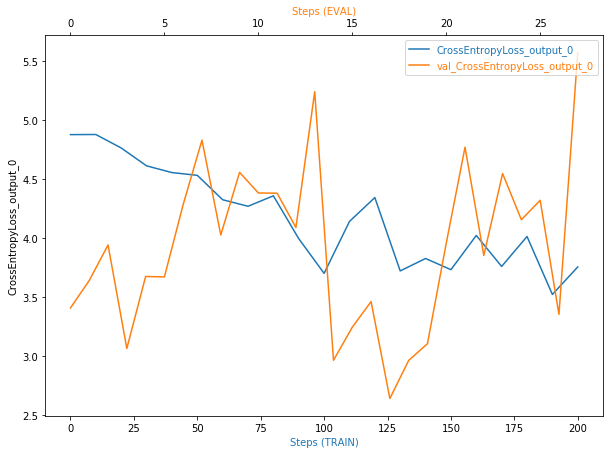

In [28]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

There is no anomalous behaviour in the debugger output, we see that the training loss generally decreases with the number of steps. Although Validation Losses are logged more frequently than training losses, we see that the validation loss is somewhat more variable than the training loss. 

With more AWS credits, I would try out different Model Architectures on top of the ResNet50 (e.g., number of FC Layers) and assess the performance. Also, choice of hyperparametes to tune can also be expanded to incorporate the hyperparameters specific to ADAM Optimizer. Finally, altering some default parameters during Hyperparameter Tuning (such as number of epochs = 2) is worth exploring to see if we can get any improved performance.

In [29]:
# TODO: Display the profiler output
session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

Training jobname: pytorch-training-2022-03-08-09-21-28-487
Region: us-east-1
[2022-03-08 09:34:03.158 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-950138119485/pytorch-training-2022-03-08-09-21-28-487/debug-output
[2022-03-08 09:34:05.178 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-03-08 09:34:06.199 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.2.bias', 'gradient/ResNet_fc.2.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'layer1.2.relu_input_1', 'layer1.2.relu_input_2', 'layer2.0.relu_input_0', 'lay

You will find the profiler report in s3://sagemaker-us-east-1-950138119485/pytorch-training-2022-03-08-09-21-28-487/rule-output
2022-03-08 09:32:02     381383 pytorch-training-2022-03-08-09-21-28-487/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-03-08 09:32:02     230543 pytorch-training-2022-03-08-09-21-28-487/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-03-08 09:31:57        191 pytorch-training-2022-03-08-09-21-28-487/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-03-08 09:31:57      16405 pytorch-training-2022-03-08-09-21-28-487/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-03-08 09:31:57        126 pytorch-training-2022-03-08-09-21-28-487/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-03-08 09:31:57        129 pytorch-training-2022-03-08-09-21-28-487/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.jso

## Model Deploying

Finally, we deploy the saved model from the previous training job using a  inference scrpt **inference.py** which overrides a few functions.

In [43]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

#S3 URI of the Saved Image
model_data_artifacts = "s3://sagemaker-us-east-1-950138119485/pytorch-training-2022-03-08-09-21-28-487/output/model.tar.gz"


jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImgPredictor(Predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super( ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )
        
pytorch_model = PyTorchModel( model_data = model_data_artifacts,
                            role = role,
                             entry_point= "inference.py",
                             py_version = "py36",
                             framework_version = "1.6",
                            predictor_cls = ImgPredictor
                            )

predictor = pytorch_model.deploy( initial_instance_count = 1, instance_type = "ml.t2.medium")

-----------!

Test image Number is : 1
Testing Image Displayed Below:


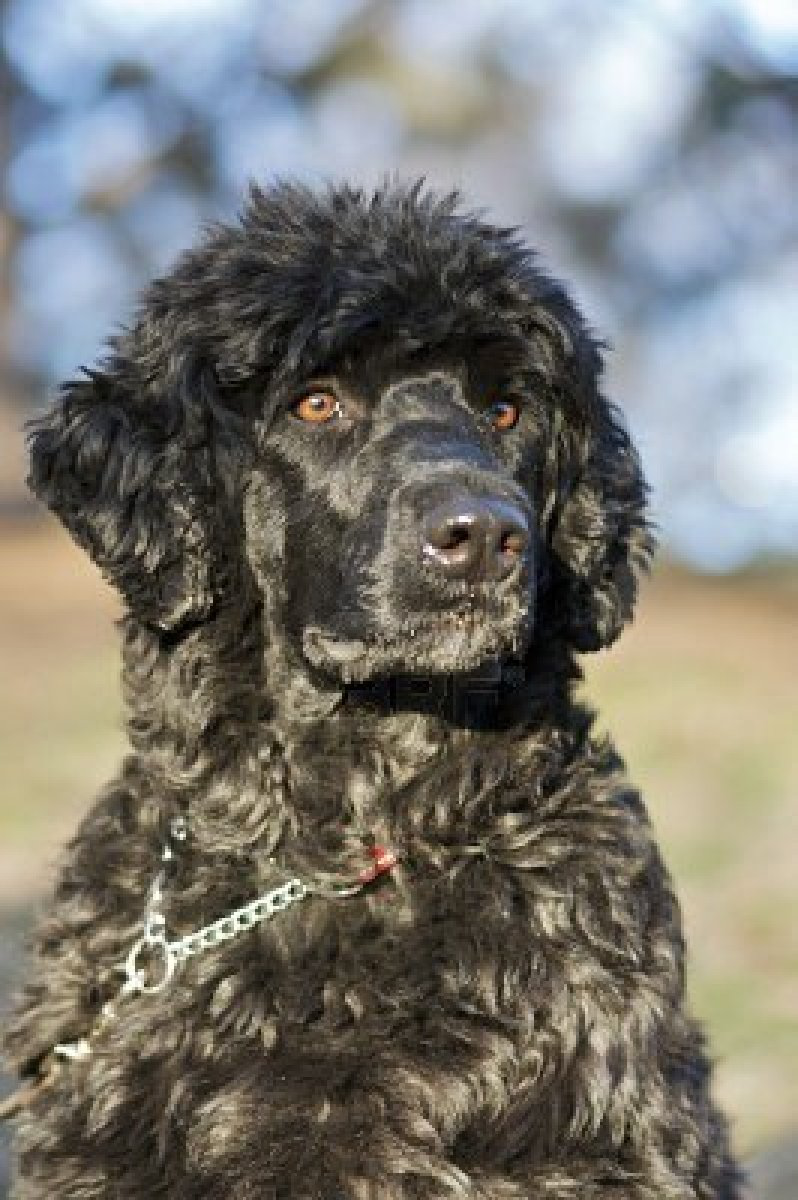

Expected dog breed is : 125
Response: [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.9901387691497803, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5643270015716553, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.305208206176758, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.3537275791168213, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3892594575881958, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.767656683921814, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3960084915161133, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.125458717346191, 4.225935459136963, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
Response/Inference for the above image is : [125]
Test image Number is : 2
Testing Image Displayed Below:


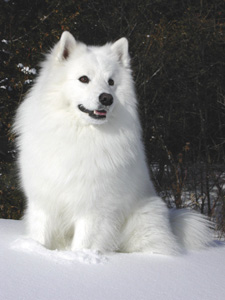

Expected dog breed is : 6
Response: [[0.0, 0.0, 0.0, 3.3088033199310303, 2.3236753940582275, 6.59813928604126, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0280004739761353, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.6408603191375732, 2.3706512451171875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0565937757492065, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3273564577102661, 0.0, 0.0, 0.02926555648446083, 0.0, 0.0, 1.0421814918518066, 0.0, 0.0, 0.8667121529579163, 0.0, 0.0, 3.5652382373809814, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1494101583957672, 0.0, 0.0, 0.0, 4.236143112182617, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.810727119445801, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004351641982793808, 0.0, 0.351303368806839, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.4384459257125854, 0.0, 0.0, 0.0, 0.0, 0.8648865818977356, 0.0, 0.0, 0.010351056233048439, 0.0, 0.0, 0.0, 0.0, 3.793471097946167, 1.8865456581115723, 0.0, 0.0, 0.0

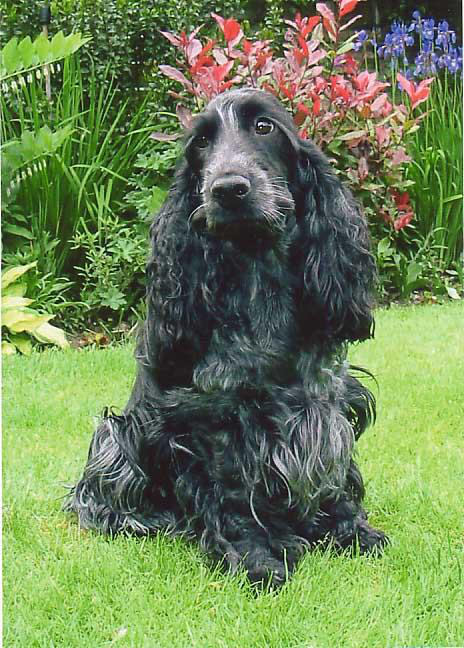

Expected dog breed is : 61
Response: [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.7607132196426392, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5905817747116089, 0.5263612866401672, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.646778404712677, 0.0, 0.0, 0.0, 0.16454344987869263, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1424838304519653, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.390188217163086, 0.6902399659156799, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.3464934825897217, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7168062925338745, 0.0, 0.0, 0.0, 0.6130655407905579, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5530281066894531, 0.0, 0.08929784595966339, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7272979021072388, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.1850321292877197, 1.992917776107788, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
Response/Inference for the above image is : [66]


In [44]:
test_dir = "./TestImages"
test_images = [ 'Portuguese_water_dog_07973.jpg', 'American_eskimo_dog_00446.jpg', 'English_cocker_spaniel_04330.jpg']

test_images_expected_output = [125, 6, 61]

for index in range(len(test_images) ):
    test_img = test_images[index]
    expected_breed_category = test_images_expected_output[index]
    print(f"Test image Number is : {index+1}")
    test_file_path = os.path.join(test_dir,test_img)
    with open(test_file_path , "rb") as f:
        payload = f.read()
        print("Testing Image Displayed Below:")
        display(Image.open(io.BytesIO(payload)))
        print(f"Expected dog breed is : {expected_breed_category}")
        response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
        print(f"Response: {response}")
        predicted_dog_breed = np.argmax(response,1) + 1
        print(f"Response/Inference for the above image is : {predicted_dog_breed}")

In [45]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

From the above three tests, we conclude that the Model is reasonably able to correctly identify Dog Breeds from the Images